# Topography Correction

by: Lu Li, UWA

Here, we show how to use 'harmonica' https://www.fatiando.org/harmonica/latest/ to remove topography effect

See https://www.fatiando.org/harmonica/latest/user_guide/topographic_correction.html for more information

In [1]:
# Load necessary package 
import harmonica as hm
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import verde as vd

# Read in Free Air Gravity Disturbance after normal earth correction

In [2]:
#Read in Gravity data after drift correction
Data = pd.read_csv('example data/Free_Air_Grav_CAGE.csv', delimiter=r',')

In [3]:
# Let's looks few line of the data
Data.head(5)

,Lon,Lat,Height Sea Level,Total Gravity,Free Air Disturbance
0,21.077,-31.156,1096.9,979100.000000,22.308253
1,20.011,-31.593,1119.4,979166.631395,60.785578
2,20.019,-31.689,1174.7,979168.331228,71.798325
3,20.019,-31.841,1357.8,979143.988157,91.644316
4,20.019,-31.381,1069.6,979154.723253,50.574405


# Topography correction

We need to remove the 3D topography mass from the Free Air disturbance. Here we use DEM from global topography grid to do that. You could use high resolution topography grid in your own study area.

Important: Remember to match the topography resolution with gravity

In [4]:
# Load southern-africa-topography grid
import xarray as xr
topography = xr.load_dataarray('example data/southern-africa-topography.nc')
topography

C:\Users\00103168\Anaconda3\envs\harmonica\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)>
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -3835., -3860., -3870.],
       ...,
       [-2906., -2901., -2884., ...,   173.,   134.,   118.],
       [-2908., -2906., -2888., ...,   132.,   119.,   118.],
       [-2912., -2910., -2894., ...,   122.,   120.,   128.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 10.92 10.93 10.95 10.97 ... 33.72 33.73 33.75
  * latitude   (latitude) float64 -36.0 -35.98 -35.97 ... -16.35 -16.33 -16.32
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

In [5]:
# Let's crop it to the gravity region (slightly larger):
region = vd.get_region((Data.Lon, Data.Lat))
region_pad = vd.pad_region(region, pad=1)

topography = topography.sel(
    longitude=slice(region_pad[0], region_pad[1]),
    latitude=slice(region_pad[2], region_pad[3]),
)
topography

<xarray.DataArray 'topography' (latitude: 239, longitude: 239)>
array([[ 208.,  524.,  949., ...,  938.,  921.,  903.],
       [ 236.,  630.,  983., ...,  919.,  909.,  897.],
       [ 241.,  607.,  873., ...,  901.,  894.,  884.],
       ...,
       [ 713.,  670.,  654., ..., 1277., 1300., 1342.],
       [ 709.,  682.,  597., ..., 1305., 1328., 1339.],
       [ 579.,  551.,  647., ..., 1337., 1350., 1332.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 19.02 19.03 19.05 19.07 ... 22.95 22.97 22.98
  * latitude   (latitude) float64 -32.98 -32.97 -32.95 ... -29.05 -29.03 -29.02
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

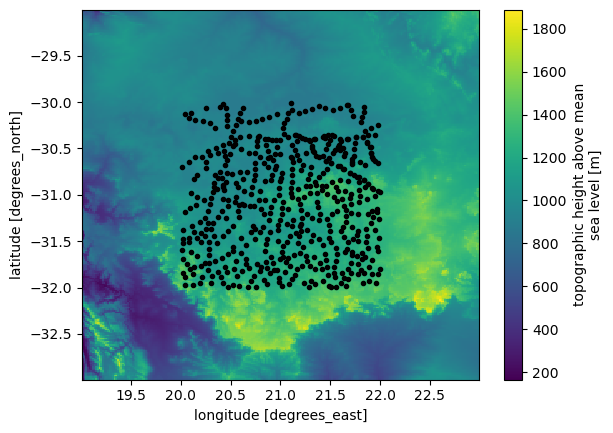

In [6]:
topography.plot()
plt.plot(Data['Lon'], Data['Lat'],'k.')

# Projection

Right now everything is in Geographic coordinate system (longtidude and latitude), in small scales, projection system in meters will be easier to handle. So here, we try to project the location to a projection system. We start by defining a Mercator projection:

In [7]:
# Define the projection
projection = pyproj.Proj(proj="merc", lat_ts=topography.latitude.values.mean())

# Project the topography grid use verde
topography_proj = vd.project_grid(topography, projection, method="nearest")
topography_proj

# We also need to project the gravity location:
# Project the coordinates of the observation points
easting, northing = projection(Data.Lon.values, Data.Lat.values)
coordinates = (easting, northing, Data['Height Sea Level'])

# Calculate topography graivty effect

We want to compute topography graivty effect use harmonica.DatasetAccessorPrismLayer.gravity, it generate a series of prism to represent the topography, and then do forward gravity calculation. In order to do that, we also need to define the density distribution first.

For every prism above the ellipsoid we will set the density of the upper crust (2670 kg/m3), while for each prism below it we will assign the density contrast equal to the density of the water (1040 kg/m3) minus the density of the upper crust.

You could change the density value to fit your local geology

In [8]:
density = np.where(topography_proj >= 0, 2670, 1040 - 2670)

prisms = hm.prism_layer(
    (topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": density},
)
prisms

<xarray.Dataset>
Dimensions:   (northing: 239, easting: 239)
Coordinates:
  * easting   (easting) float64 1.816e+06 1.818e+06 ... 2.193e+06 2.195e+06
  * northing  (northing) float64 -3.32e+06 -3.318e+06 ... -2.882e+06 -2.88e+06
    top       (northing, easting) float32 208.0 736.5 ... 1.337e+03 1.337e+03
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int32 2670 2670 2670 2670 ... 2670 2670 2670
Attributes:
    coords_units:      meters
    properties_units:  SI

In [9]:
# Compute the terrain effect
terrain_effect = prisms.prism_layer.gravity(coordinates, field="g_z")

In [10]:
# The topography-free gravity disturbance:
topo_free_disturbance = Data['Free Air Disturbance'] - terrain_effect

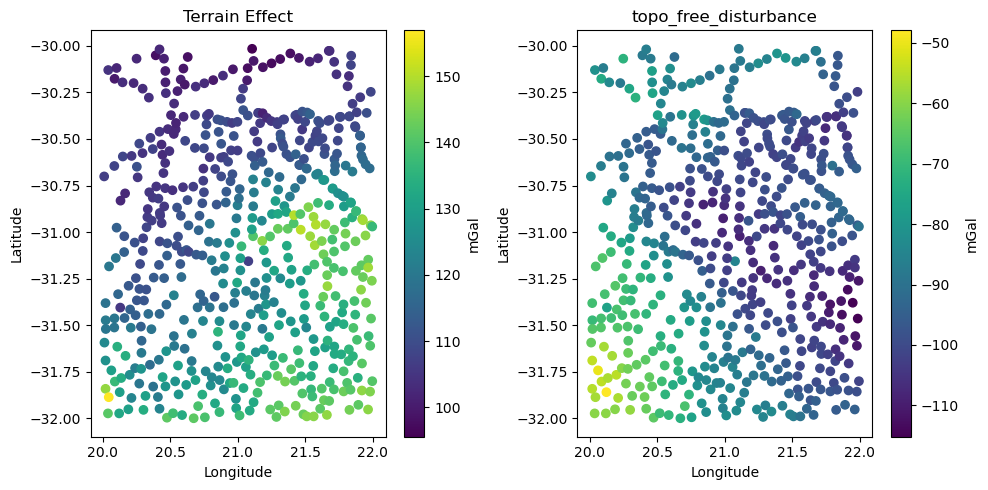

In [11]:
# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Drift over time
sc = axs[0].scatter(Data['Lon'], Data['Lat'], c=terrain_effect, cmap='viridis')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_title("Terrain Effect")
plt.colorbar(sc, ax=axs[0], label='mGal')

# Second subplot: Drift for each locations
sc = axs[1].scatter(Data['Lon'], Data['Lat'], c=topo_free_disturbance, cmap='viridis')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_title("topo_free_disturbance")
plt.colorbar(sc, ax=axs[1], label='mGal')

# Display the plot
plt.tight_layout()
plt.show()

In [12]:
# Save the Data to a CSV file
data_array = np.column_stack((Data['Lon'], Data['Lat'], easting, northing, Data['Height Sea Level'], Data['Total Gravity'], Data['Free Air Disturbance'],topo_free_disturbance))
df = pd.DataFrame(data_array, columns=['Lon', 'Lat', 'Easting', 'Northing', 'Height Sea Level', 'Total Gravity', 'Free Air Disturbance','Topo Free Disturbance'])
df.to_csv('example data/Topo_Free_Grav_CAGE.csv', index=False)

In the next notebook, we will show how to do data processing (including griding and filter the data), and prepare the final input for inversion